In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [ ]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

In [ ]:
df_train.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
37934,09/20/2021/10:20,30.3541,44.95,5.07481,546.600,62.210,69704.997753
31917,08/09/2021/15:30,35.5865,41.38,5.05112,623.700,284.900,99443.498147
28331,07/15/2021/17:50,30.8485,72.70,5.06554,412.500,134.900,89005.901292
19788,05/17/2021/10:00,25.6676,55.79,5.06348,660.800,653.600,75247.019863
23348,06/11/2021/03:20,20.3425,66.28,0.08446,0.066,0.107,77042.028189


## Первичный анализ данных

Посмотрим как распределятся все характеиристики датафрейма, обратим внимание на то что "Скорость ветра" и "Диффузивные потоки" имеют небольшую дисперсию.

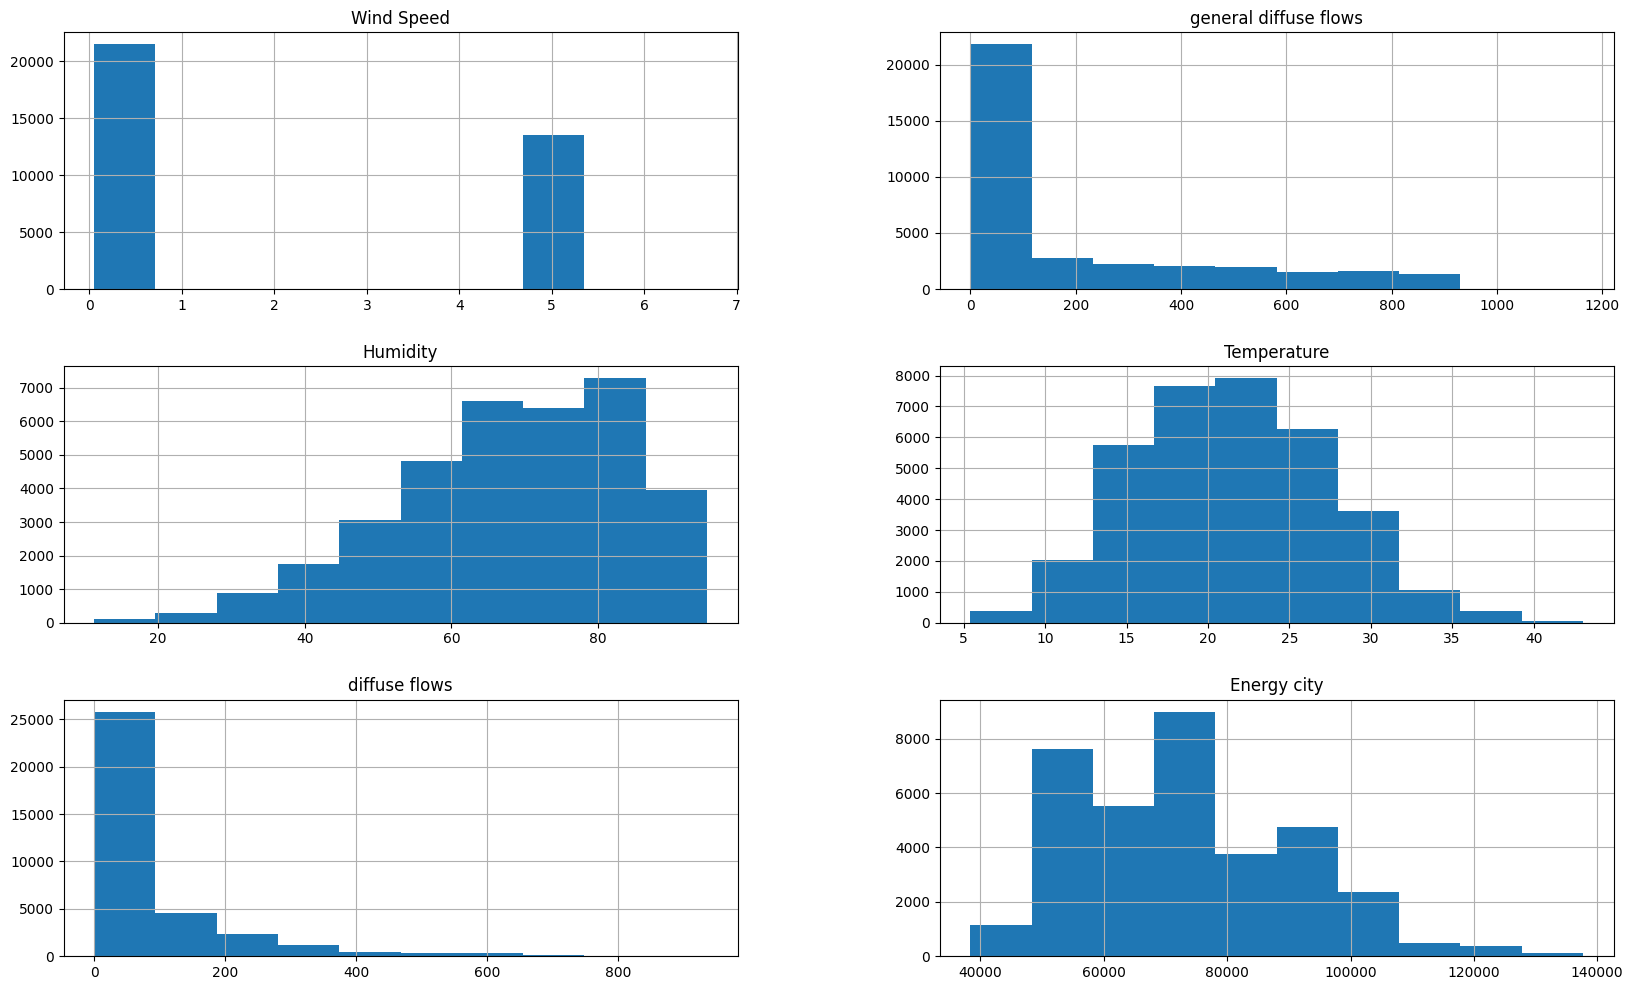

In [ ]:
features = list(set(df_train.columns) - set(['DateTime']))

_ = df_train[features].hist(figsize=(20,12))

Посмотрим на то как значения корррелируют между собой, если какая-то пара значений имеет большой коэффициент то одно из них можно выкинуть

<ipython-input-6-4dc553893bbb>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


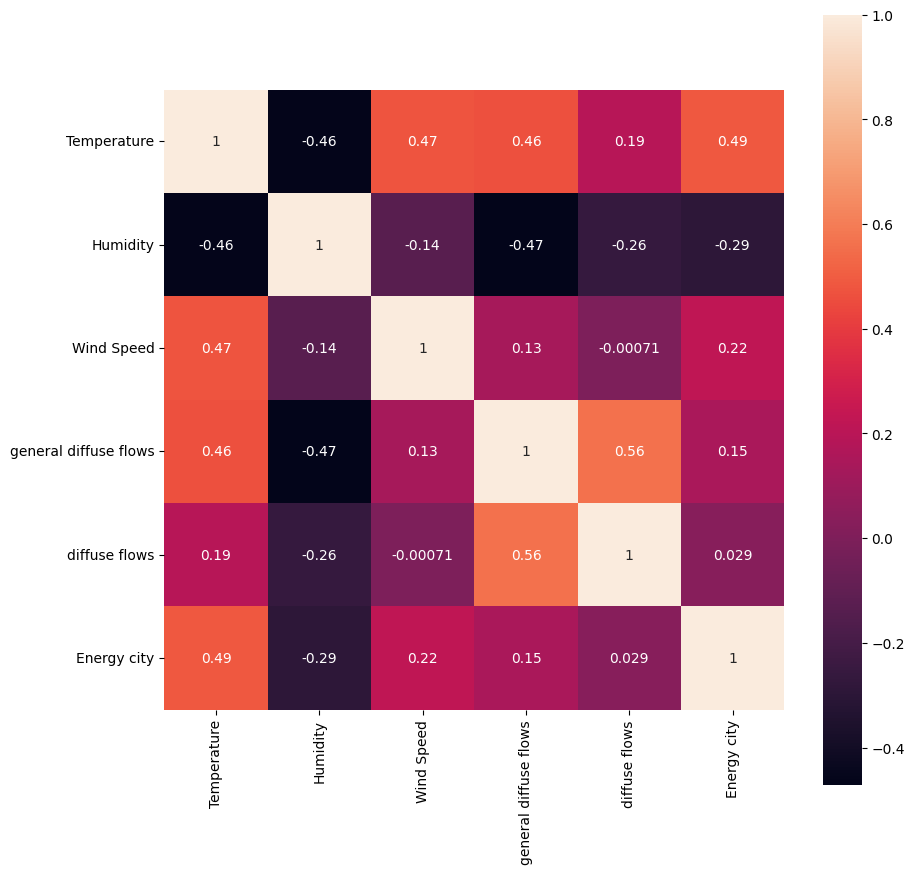

In [ ]:
plt.rcParams['figure.figsize']=(10,10)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

In [ ]:
df_train["DateTime"] = pd.to_datetime(df_train["DateTime"])

In [ ]:
df_train["Month"] = pd.to_datetime(df_train["DateTime"]).dt.month
df_train["Hour"] = pd.to_datetime(df_train["DateTime"]).dt.hour

In [ ]:
df_train.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city,Month,Hour
37934,2021-09-20 10:20:00,30.3541,44.95,5.07481,546.600,62.210,69704.997753,9,10
31917,2021-08-09 15:30:00,35.5865,41.38,5.05112,623.700,284.900,99443.498147,8,15
28331,2021-07-15 17:50:00,30.8485,72.70,5.06554,412.500,134.900,89005.901292,7,17
19788,2021-05-17 10:00:00,25.6676,55.79,5.06348,660.800,653.600,75247.019863,5,10
23348,2021-06-11 03:20:00,20.3425,66.28,0.08446,0.066,0.107,77042.028189,6,3


In [ ]:
X = df_train.drop(["Energy city", "DateTime"], axis = 1)
y = df_train["Energy city"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Month,Hour
20796,22.0626,75.60,5.06966,673.300,664.600,5,10
12516,21.8875,49.68,5.06348,0.059,0.096,3,22
26315,29.5713,69.85,5.07069,386.300,308.800,7,17
28424,30.3438,65.90,5.07481,504.300,91.000,7,9
19952,25.6882,62.90,0.07313,899.000,125.200,5,13


In [ ]:
models = [LinearRegression(),        # метод наименьших квадратов
	          RandomForestRegressor(), # случайный лес
	          KNeighborsRegressor(),   # метод ближайших соседей
	          SVR(kernel='linear'),
						]    # метод опорных векторов с линейным ядром

In [ ]:
#model = models[1].fit(X_train, y_train)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
parameters = {    'n_estimators' : [None, 100 , 500, 1000],
                  'max_depth'    : [2, 3, 5, None]
                 }
G_RFM = GridSearchCV(estimator=models[1], param_grid = parameters, cv = 3, n_jobs=-1)
G_RFM.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, None],
                         'n_estimators': [None, 100, 500, 1000]})

In [ ]:
y_prediction = G_RFM.predict(X_test)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",G_RFM.best_estimator_)
print("\n The best score across ALL searched params:\n",G_RFM.best_score_)
print("\n The best parameters across ALL searched params:\n",G_RFM.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(n_estimators=500)

 The best score across ALL searched params:
 0.961134363163436

 The best parameters across ALL searched params:
 {'max_depth': None, 'n_estimators': 500}


In [ ]:
knnr = KNeighborsRegressor()
knnr.fit(X_train,y_train)
r2_score(y_test, knnr.predict(X_test))

0.858821454352922

In [ ]:
r2_score(y_test, G_RFM.predict(X_test))

0.9671360441564918

## Генерация ответа

In [ ]:
from sklearn import linear_model
clf = linear_model.BayesianRidge()
clf.fit(X_train,y_train)

BayesianRidge()

In [ ]:
y_prediction = clf.predict(X_test)

In [ ]:
r2_score(y_test, clf.predict(X_test))

0.6195262954660492

In [ ]:
X = df_test.drop(["Energy city", "DateTime"], axis = 1)
X["Month"] = pd.to_datetime(df_test["DateTime"]).dt.month
X["Hour"] = pd.to_datetime(df_test["DateTime"]).dt.hour

In [ ]:
df_test["Energy city"] = G_RFM.predict(X)

In [ ]:
df_test.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
15506,04/17/2021/16:20,25.5028,29.73,0.08755,615.500,664.800,71780.743486
51943,12/26/2021/17:10,18.4576,54.44,0.08755,19.120,19.340,89498.560710
212,01/01/2021/11:20,17.5924,57.23,0.07828,396.600,40.660,69438.332352
11210,03/18/2021/20:20,14.8526,72.30,0.08343,0.062,0.148,96563.827969
16307,04/23/2021/05:50,17.0774,80.60,0.08240,0.018,0.204,49348.817367


In [ ]:
df_test.sort_index().to_csv("submit.csv")